In [3]:
%pip install statsmodels==0.13.2

     |████████████████████████████████| 9.8 MB 17.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


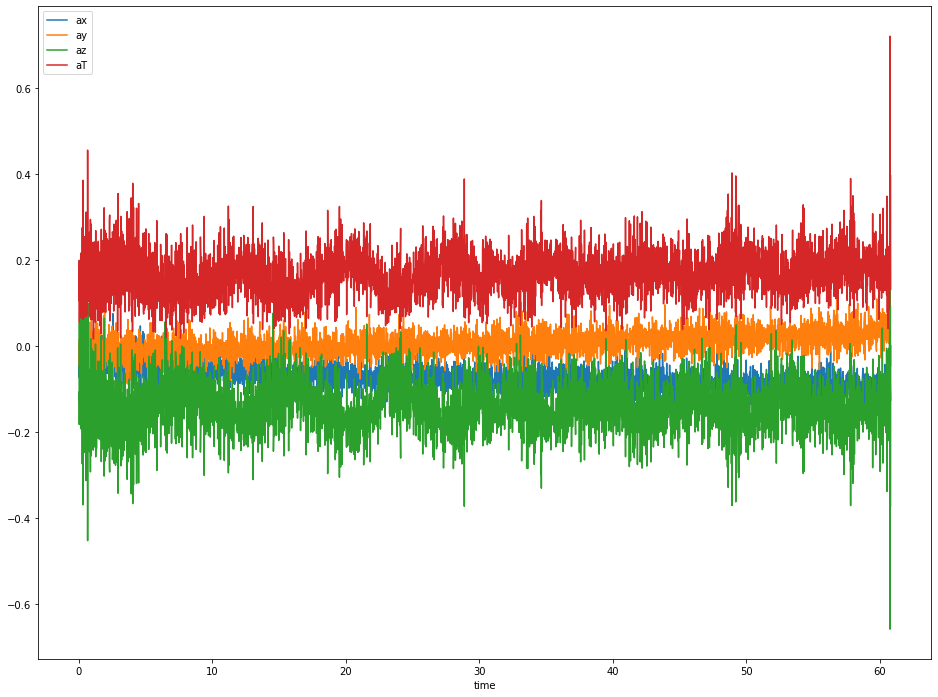

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy import array
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import math

pdf = pd.read_csv("Golden Gate Bridge Accelerometer Data.csv")

fig, ax = plt.subplots(figsize=(16, 12))

pdf.plot(x="time", y="ax", ax=ax)
pdf.plot(x="time", y="ay", ax=ax)
pdf.plot(x="time", y="az", ax=ax)
pdf.plot(x="time", y="aT", ax=ax)










In [ ]:
import time 
current_time = time.time()

pdf["time"] += current_time
pdf["time"] = pd.to_datetime(pdf["time"],unit="s")


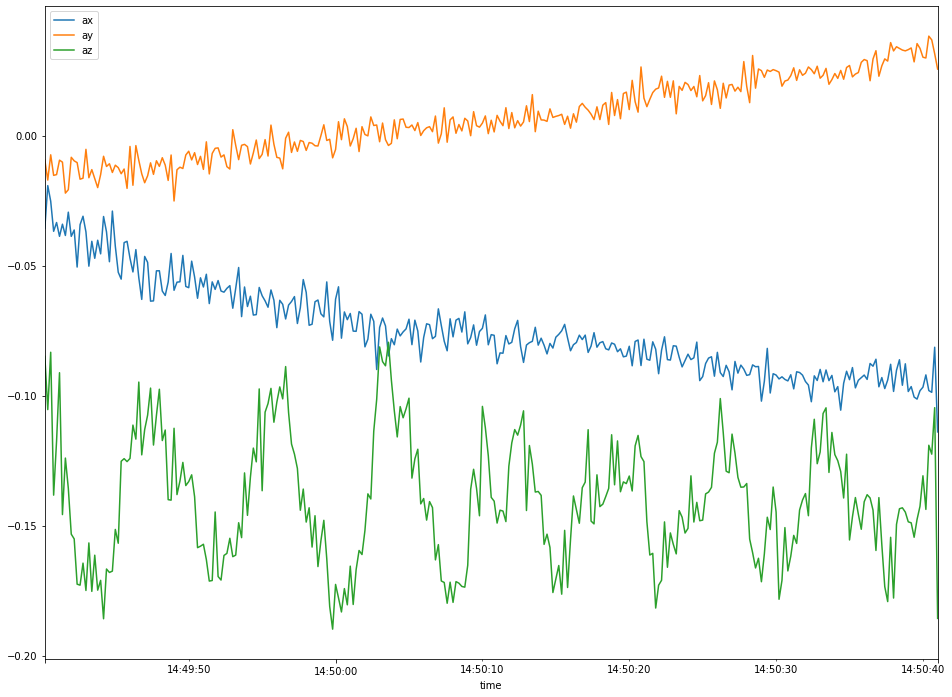

In [ ]:
rpdf = pdf.loc[:, pdf.columns != 'aT'].set_index("time").resample("200ms").mean()

fig, ax = plt.subplots(figsize=(16, 12))

rpdf.plot(y="ax", ax=ax)
rpdf.plot( y="ay", ax=ax)
rpdf.plot( y="az", ax=ax)

In [ ]:
#az = rpdf['az'].values.reshape(-1,1)
#scaler= StandardScaler()
#sc = scaler.fit_transform(az)
#az=sc
scaler= StandardScaler()
rpdf['ax'] = scaler.fit_transform(rpdf['ax'].values.reshape(-1,1))
rpdf['az'] = scaler.fit_transform(rpdf['az'].values.reshape(-1,1))
rpdf['ay'] = scaler.fit_transform(rpdf['ay'].values.reshape(-1,1))
az=rpdf['az'].values

In [ ]:

def split_data(data, training_part=0.8, step_size=20, predicted_size=6):
    train_length= int(len(data) * training_part)
    x_train = []
    y_train = []
    x_val = []
    y_val = []

    data_train = data[:train_length]
    data_val = data[train_length:]

    for i in range(0, len(data_train) - (step_size + predicted_size)):
      x_train.append(data_train[i:i+step_size])
      y_train.append(data_train[i+step_size:i+step_size+predicted_size])

    for i in range(0, len(data_val) - (step_size + predicted_size)):
      x_val.append(data_val[i:i+step_size])
      y_val.append(data_val[i+step_size:i+step_size+predicted_size])
    
    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val)



# 1feature, 20steps, 6predicted

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(20, 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 121,806
Trainable params: 121,806
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train, y_train, x_val, y_val = split_data(az)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, verbose=True)

Epoch 1/50
7/7 [==============================] - 9s 344ms/step - loss: 1.0080 - val_loss: 0.4587
Epoch 2/50
7/7 [==============================] - 1s 79ms/step - loss: 0.9408 - val_loss: 0.4283
Epoch 3/50
7/7 [==============================] - 1s 96ms/step - loss: 0.7046 - val_loss: 0.3249
Epoch 4/50
7/7 [==============================] - 1s 87ms/step - loss: 0.5111 - val_loss: 0.2811
Epoch 5/50
7/7 [==============================] - 2s 268ms/step - loss: 0.4774 - val_loss: 0.3049
Epoch 6/50
7/7 [==============================] - 1s 113ms/step - loss: 0.4125 - val_loss: 0.2499
Epoch 7/50
7/7 [==============================] - 1s 81ms/step - loss: 0.4088 - val_loss: 0.2543
Epoch 8/50
7/7 [==============================] - 1s 222ms/step - loss: 0.3832 - val_loss: 0.2562
Epoch 9/50
7/7 [==============================] - 0s 48ms/step - loss: 0.3581 - val_loss: 0.2630
Epoch 10/50
7/7 [==============================] - 0s 45ms/step - loss: 0.3750 - val_loss: 0.2642
Epoch 11/50
7/7 [========

Text(0.5, 1.0, 'Model Loss')

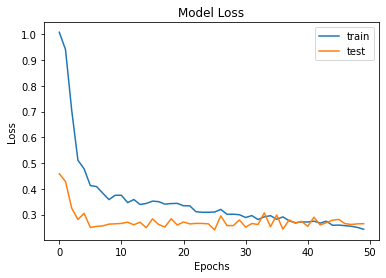

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('train','test'))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

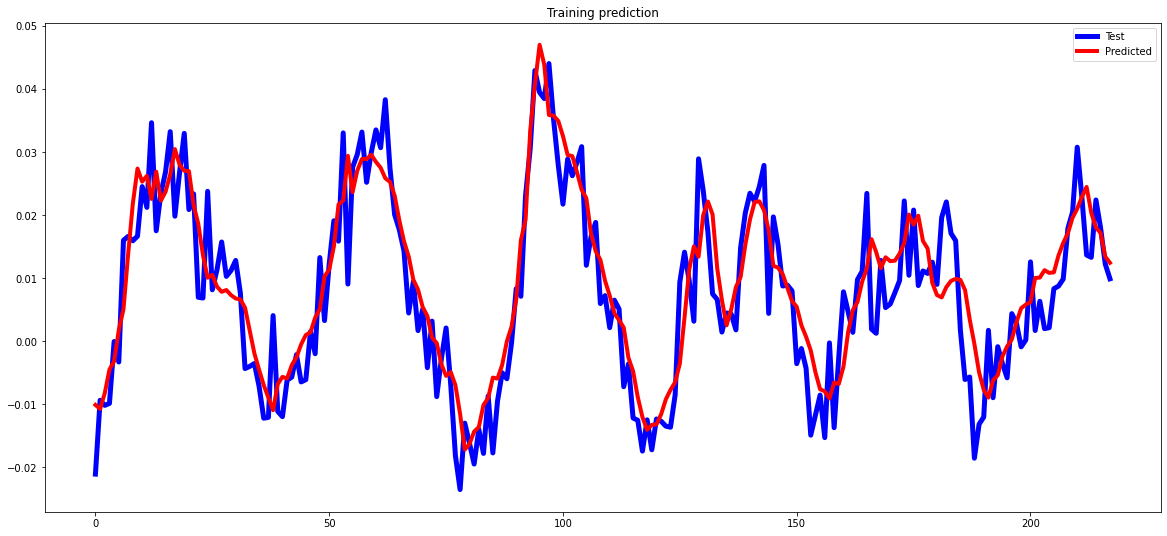

Training Score: 0.47 RMSE


In [ ]:
preds = model.predict(x_train) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_train[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)),'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Training prediction")
plt.show()

trainingScore = math.sqrt(mean_squared_error(y_train[:,0], preds[:,0]))
print('Training Score: %.2f RMSE' % (trainingScore))

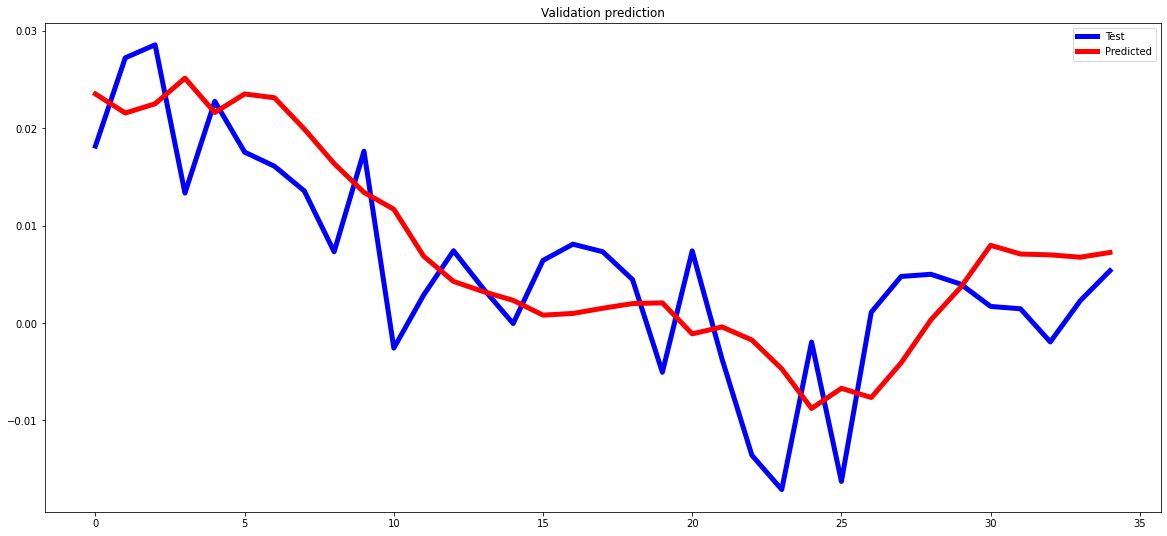

Validation Score: 0.49 RMSE


In [ ]:
preds = model.predict(x_val) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_val[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)), 'red', linewidth=5)
plt.legend(('Test','Predicted'))
plt.title("Validation prediction")
plt.show()

testScore = math.sqrt(mean_squared_error(y_val[:,0], preds[:,0]))
print('Validation Score: %.2f RMSE' % (testScore))

# 1feature, 30steps, 6predicted

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(30, 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 6)                 606       
                                                                 
Total params: 121,806
Trainable params: 121,806
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train, y_train, x_val, y_val = split_data(az,step_size=30)

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, verbose=True)

Epoch 1/50
7/7 [==============================] - 3s 130ms/step - loss: 1.0152 - val_loss: 0.4486
Epoch 2/50
7/7 [==============================] - 0s 64ms/step - loss: 0.9252 - val_loss: 0.4631
Epoch 3/50
7/7 [==============================] - 0s 61ms/step - loss: 0.6704 - val_loss: 0.3240
Epoch 4/50
7/7 [==============================] - 0s 64ms/step - loss: 0.5024 - val_loss: 0.3030
Epoch 5/50
7/7 [==============================] - 2s 250ms/step - loss: 0.4603 - val_loss: 0.3151
Epoch 6/50
7/7 [==============================] - 0s 62ms/step - loss: 0.3892 - val_loss: 0.2263
Epoch 7/50
7/7 [==============================] - 1s 183ms/step - loss: 0.3721 - val_loss: 0.2559
Epoch 8/50
7/7 [==============================] - 0s 60ms/step - loss: 0.3645 - val_loss: 0.2269
Epoch 9/50
7/7 [==============================] - 0s 58ms/step - loss: 0.3656 - val_loss: 0.2274
Epoch 10/50
7/7 [==============================] - 1s 90ms/step - loss: 0.3393 - val_loss: 0.2147
Epoch 11/50
7/7 [=========

Text(0.5, 1.0, 'Model Loss')

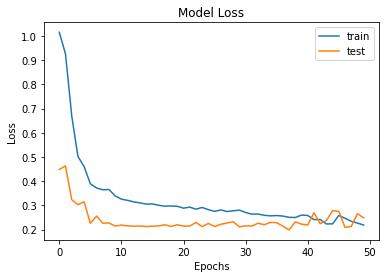

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('train','test'))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

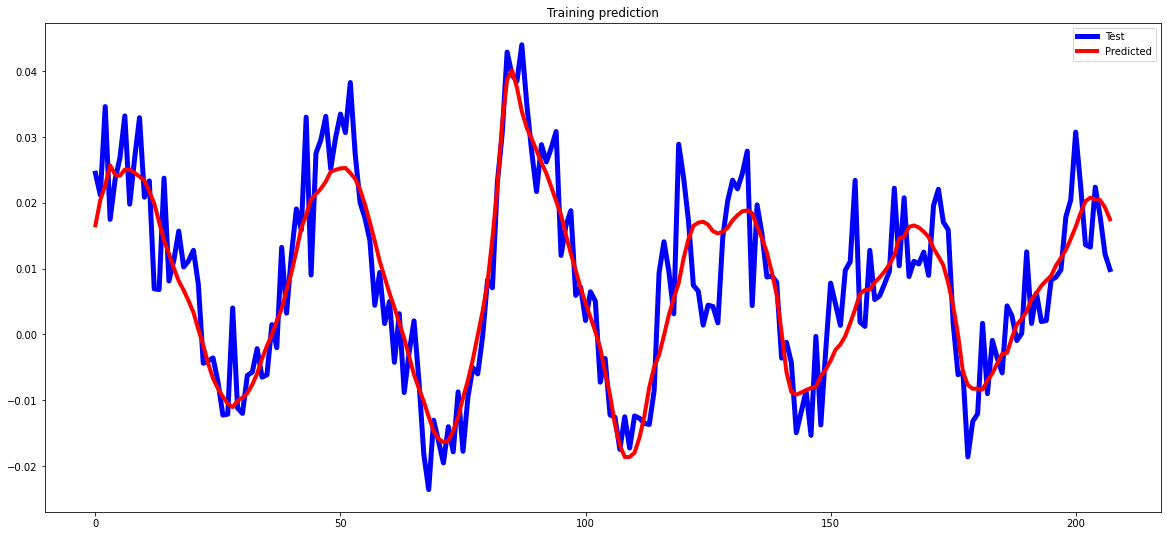

Training Score: 0.46 RMSE


In [ ]:
preds = model.predict(x_train) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_train[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)),'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Training prediction")
plt.show()

trainingScore = math.sqrt(mean_squared_error(y_train[:,0], preds[:,0]))
print('Training Score: %.2f RMSE' % (trainingScore))

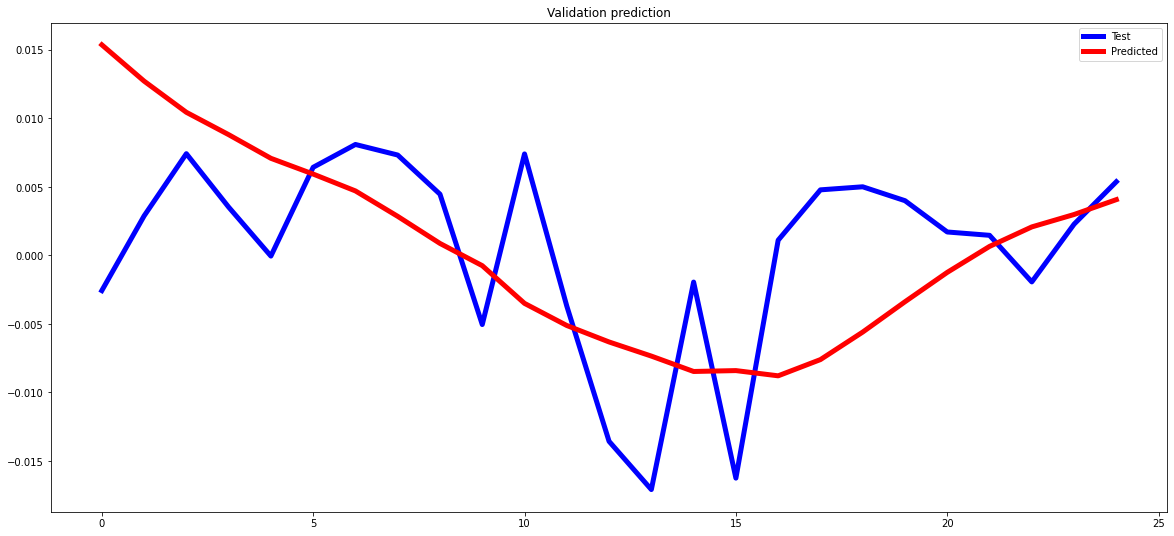

Validation Score: 0.52 RMSE


In [ ]:
preds = model.predict(x_val) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_val[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)), 'red', linewidth=5)
plt.legend(('Test','Predicted'))
plt.title("Validation prediction")
plt.show()

testScore = math.sqrt(mean_squared_error(y_val[:,0], preds[:,0]))
print('Validation Score: %.2f RMSE' % (testScore))

# 3features, 20steps, 6predicted

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(20, 3)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(6))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 100)           41600     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 6)                 606       
                                                                 
Total params: 122,606
Trainable params: 122,606
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
x_train, y_train, x_val, y_val = split_data(rpdf)
y_train = y_train[:,:,-1]
y_val = y_val[:,:,-1]

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, verbose=True)

Epoch 1/50
7/7 [==============================] - 7s 282ms/step - loss: 1.0073 - val_loss: 0.4825
Epoch 2/50
7/7 [==============================] - 1s 81ms/step - loss: 0.9267 - val_loss: 0.4540
Epoch 3/50
7/7 [==============================] - 1s 87ms/step - loss: 0.7515 - val_loss: 0.3843
Epoch 4/50
7/7 [==============================] - 1s 147ms/step - loss: 0.6228 - val_loss: 0.3328
Epoch 5/50
7/7 [==============================] - 1s 148ms/step - loss: 0.4417 - val_loss: 0.2941
Epoch 6/50
7/7 [==============================] - 2s 377ms/step - loss: 0.3885 - val_loss: 0.3267
Epoch 7/50
7/7 [==============================] - 1s 138ms/step - loss: 0.3606 - val_loss: 0.5306
Epoch 8/50
7/7 [==============================] - 1s 145ms/step - loss: 0.3398 - val_loss: 0.5837
Epoch 9/50
7/7 [==============================] - 1s 93ms/step - loss: 0.3331 - val_loss: 0.4763
Epoch 10/50
7/7 [==============================] - 1s 226ms/step - loss: 0.3182 - val_loss: 0.3944
Epoch 11/50
7/7 [=====

Text(0.5, 1.0, 'Model Loss')

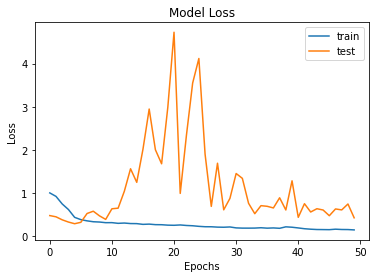

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(('train','test'))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")

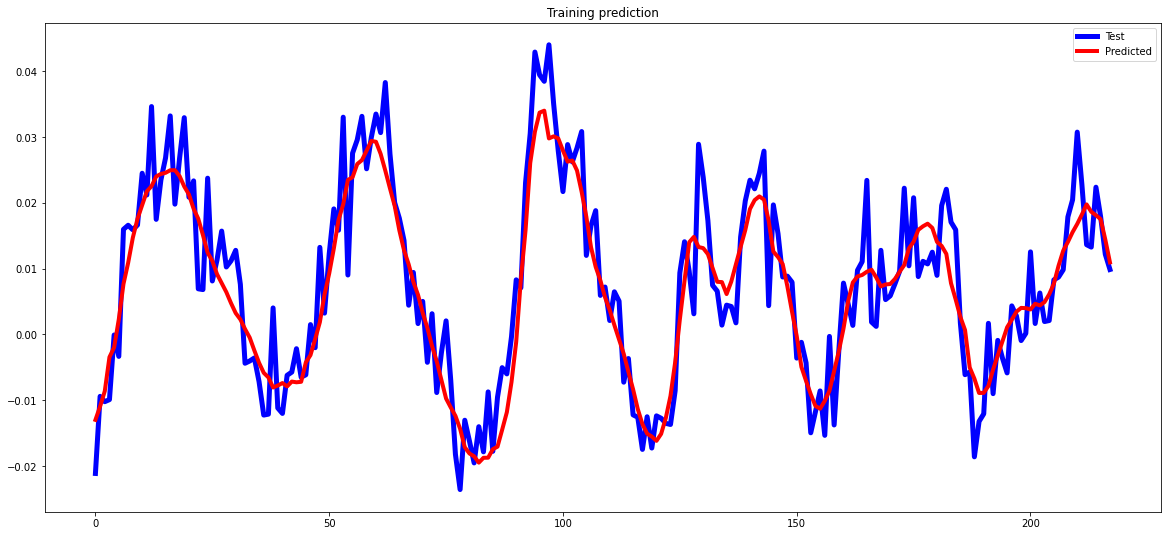

Training Score: 0.41 RMSE


In [ ]:
preds = model.predict(x_train) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_train[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)),'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Training prediction")
plt.show()

trainingScore = math.sqrt(mean_squared_error(y_train[:,0], preds[:,0]))
print('Training Score: %.2f RMSE' % (trainingScore))

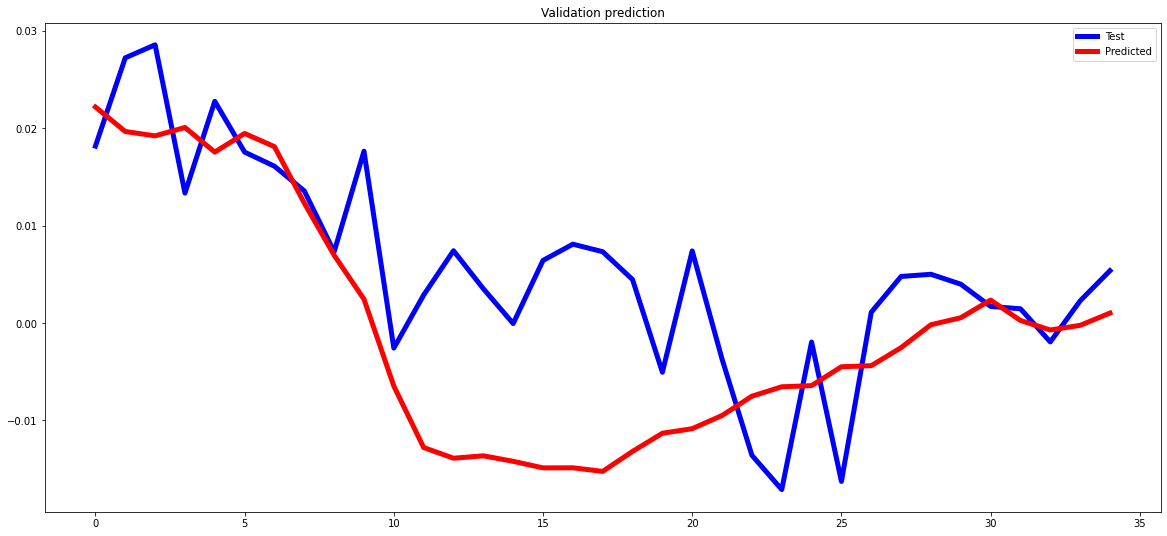

Validation Score: 0.77 RMSE


In [ ]:
preds = model.predict(x_val) 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(y_val[:,0].reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds[:,0].reshape(-1,1)), 'red', linewidth=5)
plt.legend(('Test','Predicted'))
plt.title("Validation prediction")
plt.show()

testScore = math.sqrt(mean_squared_error(y_val[:,0], preds[:,0]))
print('Validation Score: %.2f RMSE' % (testScore))

# Holt-Winters ES


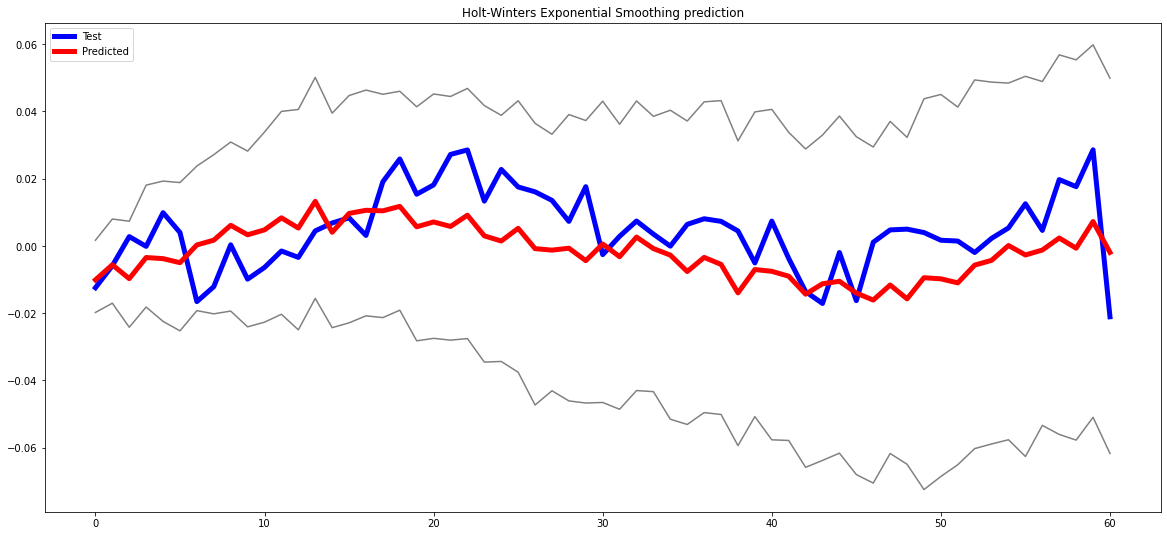

Validation Score: 0.85 RMSE


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

az_train_length = int(len(az)*0.8)
az_test_length = int(len(az)*0.2)

az = rpdf['az']


model = HWES(az[:az_train_length], seasonal_periods=46, trend='add', seasonal='add')
fitted = model.fit()


preds = fitted.forecast(az_test_length)
simulations = fitted.simulate(az_test_length, repetitions=100, error="add")
upper_ci = simulations.quantile(q=0.9, axis='columns')
lower_ci = simulations.quantile(q=0.1, axis='columns')

 
plt.figure(figsize=(20,9))
plt.plot(scaler.inverse_transform(az[az_train_length:].values.reshape(-1,1)), 'blue', linewidth=5)
plt.plot(scaler.inverse_transform(preds.values.reshape(-1,1)), 'red', linewidth=5)
plt.plot(scaler.inverse_transform(lower_ci.values.reshape(-1,1)), color="grey")
plt.plot(scaler.inverse_transform(upper_ci.values.reshape(-1,1)), color="grey")



plt.legend(('Test','Predicted'))
plt.title("Holt-Winters Exponential Smoothing prediction")
plt.show()

testScore = math.sqrt(mean_squared_error(az[az_train_length:].values, preds.values))
print('Validation Score: %.2f RMSE' % (testScore))